In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from dotenv import load_dotenv
import os
load_dotenv()

from fredapi import Fred

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
import numpy

from scipy import stats

2024-02-15 18:35:41.715243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
api_key = os.getenv('FRED_API_KEY')
# base_url = f"https://api.stlouisfed.org/fred/series/observations?api_key={api_key}&file_type=json"
fred = Fred(api_key=api_key)

In [3]:
fred_timeseries_mapping = {
    'CPIAUCSL': 'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average',
    'HOUST': 'New Privately-Owned Housing Units Started: Total Units',
    'CSUSHPINSA': 'S&P CoreLogic Case-Shiller U.S. National Home Price Index',
    'HPIPONM226S': 'Purchase Only House Price Index for the United States',
    'WSCNDW01USQ470S': 'Work Started: Construction: Dwellings and Residential Buildings: Total for United States',
    'ETOTALUSQ176N': 'Housing Inventory Estimate: Total Housing Units in the United States',
    'USSTHPI': 'All-Transactions House Price Index for the United States',
    'WPUSI012011': 'Producer Price Index by Commodity: Special Indexes: Construction Materials',
    'ILSTHPI': 'All-Transactions House Price Index for Illinois',
    'MORTGAGE30US': '30-Year Fixed Rate Mortgage Average in the United States',
    'MORTGAGE15US': '15-Year Fixed Rate Mortgage Average in the United States',
    'MSACSR': 'Monthly Supply of New Houses in the United States',
    'MSPUS': 'Median Sales Price of Houses Sold for the United States'
}

start = "1993-01-01"
#end

dfs = []

for s in list(fred_timeseries_mapping.keys()):
    data = fred.get_series(s, observation_start=start)
    df = pd.DataFrame(data)
    # get max or min to remove outliers

    df_grouped = df.groupby(by=[df.index.year, df.index.quarter]).mean()
    # display(df.isnull().any())
    dfs.append(df_grouped)
    
housing_data_df = pd.concat(dfs, axis=1)
housing_data_df.columns = list(fred_timeseries_mapping.keys())
housing_data_df.dropna(inplace=True)

housing_data_df.head(10)

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  WSCNDW01USQ470S  \
2000 2  171.433333  1586.666667  103.699000   139.566667    132222.222222   
     3  173.000000  1503.666667  106.459333   141.780000    125305.555556   
     4  174.233333  1544.000000  108.270000   144.200000    128666.666667   
2001 1  175.900000  1605.000000  109.750000   146.910000    133750.000000   
     2  177.133333  1630.000000  112.241000   149.316667    135833.333333   
     3  177.633333  1599.666667  114.893000   151.590000    133305.555556   
     4  177.500000  1570.000000  115.858667   153.943333    130833.333333   
2002 1  178.066667  1723.000000  117.094000   156.560000    143583.333333   
     2  179.466667  1691.000000  120.776333   159.420000    140916.666667   
     3  180.433333  1697.333333  124.636667   162.483333    141444.444444   

        ETOTALUSQ176N  USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  \
2000 2       116047.0   233.89   145.166667   245.58      8.316154   
     3       116482.0   238.16   143.833333   249.63      8.020000   
     4       116914.0   241.80   142.833333   252.46      7.620769   
2001 1       117347.0   247.79   142.266667   255.77      7.006923   
     2       117786.0   251.94   143.666667   260.21      7.130000   
     3       118216.0   255.85   143.233333   265.05      6.963846   
     4       118635.0   259.02   142.033333   267.50      6.770769   
2002 1       119061.0   262.73   142.466667   272.12      6.971538   
     2       119483.0   267.21   143.866667   276.94      6.813077   
     3       119909.0   272.51   145.066667   280.51      6.289231   

        MORTGAGE15US    MSACSR     MSPUS  
2000 2      7.991538  4.533333  163200.0  
     3      7.733077  4.166667  168800.0  
     4      7.294615  3.933333  172900.0  
2001 1      6.589231  3.766667  169800.0  
     2      6.660000  4.033333  179000.0  
     3      6.506923  4.333333  172500.0  
     4      6.253077  4.066667  171100.0  
2002 1      6.461538  4.100000  188700.0  
     2      6.286154  4.166667  187200.0  
     3      5.712308  4.033333  178100.0

<Axes: >

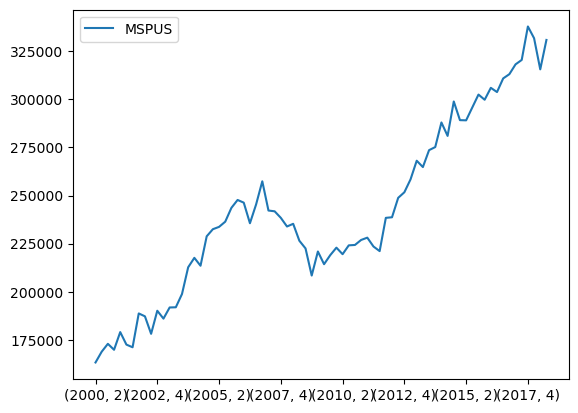

In [4]:
housing_data_df[['MSPUS']].plot()

<Axes: >

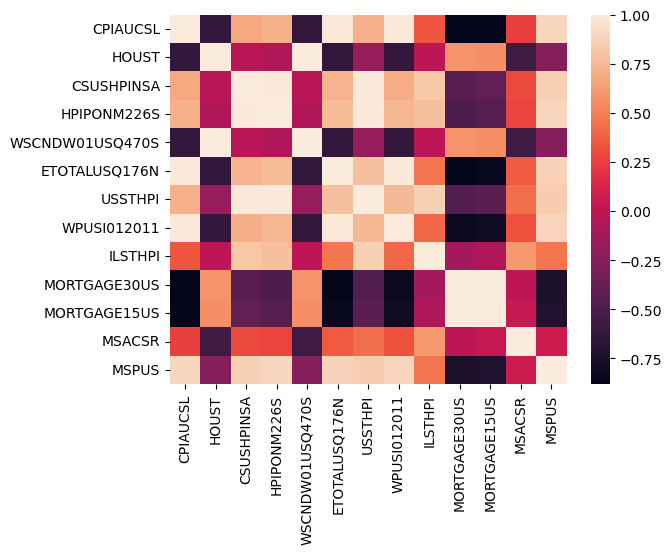

In [5]:
columns = list(fred_timeseries_mapping.keys())
sns.heatmap(housing_data_df[columns].corr())

In [6]:
# Adjust Y target for inflation

# inflation_adjustment_factor = housing_data_df.index[0][0] / housing_data_df['CPIAUCSL']
# housing_data_df['MSPUS'] = housing_data_df['MSPUS'] * inflation_adjustment_factor
# housing_data_df.drop(columns=['CPIAUCSL'], inplace=True)


In [7]:
housing_data_df.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  WSCNDW01USQ470S  \
2000 2  171.433333  1586.666667  103.699000   139.566667    132222.222222   
     3  173.000000  1503.666667  106.459333   141.780000    125305.555556   
     4  174.233333  1544.000000  108.270000   144.200000    128666.666667   
2001 1  175.900000  1605.000000  109.750000   146.910000    133750.000000   
     2  177.133333  1630.000000  112.241000   149.316667    135833.333333   

        ETOTALUSQ176N  USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  \
2000 2       116047.0   233.89   145.166667   245.58      8.316154   
     3       116482.0   238.16   143.833333   249.63      8.020000   
     4       116914.0   241.80   142.833333   252.46      7.620769   
2001 1       117347.0   247.79   142.266667   255.77      7.006923   
     2       117786.0   251.94   143.666667   260.21      7.130000   

        MORTGAGE15US    MSACSR     MSPUS  
2000 2      7.991538  4.533333  163200.0  
     3      7.733077  4.166667  168800.0  
     4      7.294615  3.933333  172900.0  
2001 1      6.589231  3.766667  169800.0  
     2      6.660000  4.033333  179000.0

## Determine if candidate for Linear Regression

#### Find best fit line

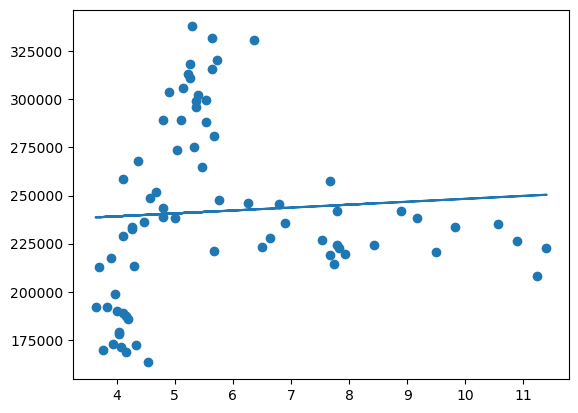

0.06540449653635591 Weak candidate for Linear Regression


In [8]:
#Linear Regression
x_lr = housing_data_df['MSACSR']
y_lr = housing_data_df['MSPUS']

slope, intercept, r, p, std_err = stats.linregress(x_lr, y_lr)

plt.scatter(x_lr, y_lr)
plt.plot(x_lr, slope * x_lr + intercept)
plt.show()

if r > .8 or r < -.8:
    print(f'{r}: Good candidate for Linear Regression')
else:
    print(f'{r} Weak candidate for Linear Regression')

## Determine if candidate for Polynomial Regression

#### like linear regression, it seeks to find a 'best fit' line but not a linear line

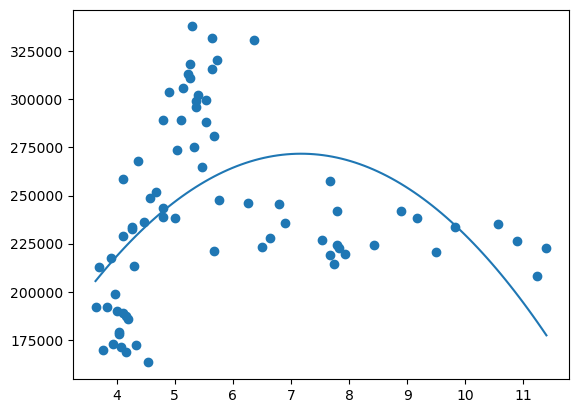

0.24556589427631403 Weak candidate for Polynomial Regression


In [9]:
#Polynomial Regression
x_pr = housing_data_df['MSACSR']
y_pr = housing_data_df['MSPUS']

mymodel = numpy.poly1d(numpy.polyfit(x_pr, y_pr, 2))
myline = numpy.linspace(min(x_pr), max(x_pr), 100)

plt.scatter(x_pr, y_pr)
plt.plot(myline, mymodel(myline))
plt.show()

r2s = r2_score(y_pr, mymodel(x_pr))

if r2s > 0.9:
    print(f'{r2s}: Good candidate for Polynomial Regression')
else:
    print(f'{r2s} Weak candidate for Polynomial Regression')

### Try Multiple Regression (i.e. linear regression with multiple variables)

In [10]:
# Create X df
X = housing_data_df.copy().drop(columns='MSPUS')
X.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  WSCNDW01USQ470S  \
2000 2  171.433333  1586.666667  103.699000   139.566667    132222.222222   
     3  173.000000  1503.666667  106.459333   141.780000    125305.555556   
     4  174.233333  1544.000000  108.270000   144.200000    128666.666667   
2001 1  175.900000  1605.000000  109.750000   146.910000    133750.000000   
     2  177.133333  1630.000000  112.241000   149.316667    135833.333333   

        ETOTALUSQ176N  USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  \
2000 2       116047.0   233.89   145.166667   245.58      8.316154   
     3       116482.0   238.16   143.833333   249.63      8.020000   
     4       116914.0   241.80   142.833333   252.46      7.620769   
2001 1       117347.0   247.79   142.266667   255.77      7.006923   
     2       117786.0   251.94   143.666667   260.21      7.130000   

        MORTGAGE15US    MSACSR  
2000 2      7.991538  4.533333  
     3      7.733077  4.166667  
     4      7.294615  3.933333  
2001 1      6.589231  3.766667  
     2      6.660000  4.033333

In [11]:
#Create y df
y = housing_data_df[['MSPUS']]
y.head()

MSPUS
2000 2  163200.0
     3  168800.0
     4  172900.0
2001 1  169800.0
     2  179000.0

In [12]:
split = round(abs(X.index.min()[0] - X.index.max()[0]) * 0.8)
split

14

In [13]:
# Slice data by date to split testing and training data

#Start
training_begin = X.index.min()[0]
training_end = X.index.min()[0] + split

display(training_begin)
display(training_end)

2000

2014

In [14]:
# Split the train data
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.tail()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  WSCNDW01USQ470S  \
2013 4  234.162667  1009.000000  159.400333   199.686667     84305.555556   
2014 1  235.621000   934.000000  160.142333   202.066667     77833.333333   
     2  236.872333   987.000000  164.621000   204.023333     82000.000000   
     3  237.478333  1030.666667  167.276000   206.270000     85750.000000   
     4  236.888333  1049.333333  166.675333   208.960000     87944.444444   

        ETOTALUSQ176N  USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  \
2013 4       133799.0   328.75   209.633333   296.70      4.293077   
2014 1       134005.0   331.45   212.600000   297.51      4.364615   
     2       134212.0   337.88   214.133333   303.03      4.227692   
     3       134423.0   342.77   215.333333   307.26      4.135385   
     4       134642.0   345.54   215.733333   308.44      3.963571   

        MORTGAGE15US    MSACSR  
2013 4      3.345385  5.033333  
2014 1      3.403077  5.333333  
     2      3.313846  5.533333  
     3      3.261538  5.666667  
     4      3.174286  5.366667

In [15]:
#Split the test data
X_test = X.loc[training_end+1:]
y_test = y.loc[training_end+1:]

X_test.isna().any()

CPIAUCSL           False
HOUST              False
CSUSHPINSA         False
HPIPONM226S        False
WSCNDW01USQ470S    False
ETOTALUSQ176N      False
USSTHPI            False
WPUSI012011        False
ILSTHPI            False
MORTGAGE30US       False
MORTGAGE15US       False
MSACSR             False
dtype: bool

In [16]:
#Scaler the feature df

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
""" 
Linear Regression finds the 'best fit' line representing the relationship between dependent variable (y)
and independent features
"""
from sklearn.linear_model import LinearRegression 
model = LinearRegression() 
model.fit(X_train_scaled, y_train)

LinearRegression()

In [18]:
print(f"Model's slope: {model.coef_}") 

Model's slope: [[ 13329.13834872   6289.66246051  -8540.56458032  36655.04687825
    4417.34237399   -388.69616425  14870.49031316   7503.9531163
  -32124.77533131 -14366.04003527  15321.67372821   2190.20748459]]


In [19]:
predicted_y_values = model.predict(X_test_scaled) 

In [20]:
# Create a copy of the original data
housing_predictions_df = housing_data_df.copy().loc[training_end+1:]

# Add a column with the predicted sales values
housing_predictions_df["MSPUS_lr_predicted"] = predicted_y_values

# Display sample data
housing_predictions_df.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  WSCNDW01USQ470S  \
2015 1  235.355000   977.000000  166.989000   211.696667     82277.777778   
     2  236.960000  1158.000000  171.756333   214.556667     96305.555556   
     3  237.855000  1166.666667  174.826000   217.210000     96750.000000   
     4  237.837000  1125.333333  175.101333   220.340000     93694.444444   
2016 1  237.689333  1142.666667  175.637667   223.000000     96111.111111   

        ETOTALUSQ176N  USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  \
2015 1       134862.0   349.35   215.366667   311.87      3.716667   
     2       135081.0   355.02   213.966667   314.57      3.819231   
     3       135309.0   360.06   213.166667   315.66      3.954615   
     4       135552.0   362.96   211.666667   317.10      3.897857   
2016 1       135795.0   366.31   211.433333   318.55      3.738462   

        MORTGAGE15US    MSACSR     MSPUS  MSPUS_lr_predicted  
2015 1      3.010833  4.800000  289200.0       289541.815424  
     2      3.056154  5.100000  289100.0       295665.420262  
     3      3.150769  5.366667  295800.0       299832.539000  
     4      3.123571  5.400000  302500.0       303688.316682  
2016 1      3.022308  5.533333  299800.0       308876.553358

<Axes: >

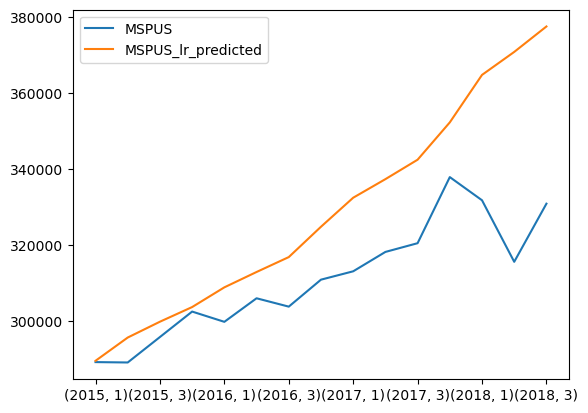

In [21]:
housing_predictions_df[['MSPUS', 'MSPUS_lr_predicted']].plot()

In [22]:
# Create a decision tree model
decision_tree_model = DecisionTreeRegressor(random_state=42)

# Train the model
decision_tree_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = decision_tree_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
housing_predictions_df["MSPUS_dt_predicted"] = y_pred

Mean Squared Error: 539174666.6666666


<Axes: >

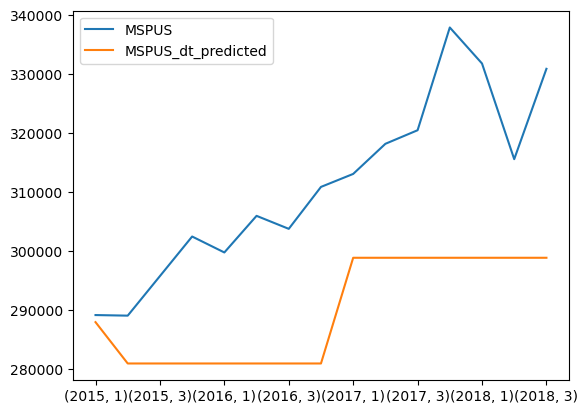

In [23]:
housing_predictions_df[['MSPUS', 'MSPUS_dt_predicted']].plot()

In [24]:
# Create a Random Forest Regressor model
random_forest_model = RandomForestRegressor(random_state=42)

# Train the model
random_forest_model.fit(X_train_scaled, y_train.values.ravel())

# Make predictions on the test set
y_pred = random_forest_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
housing_predictions_df["MSPUS_rfr_predicted"] = y_pred

Mean Squared Error: 646175542.7333333


<Axes: >

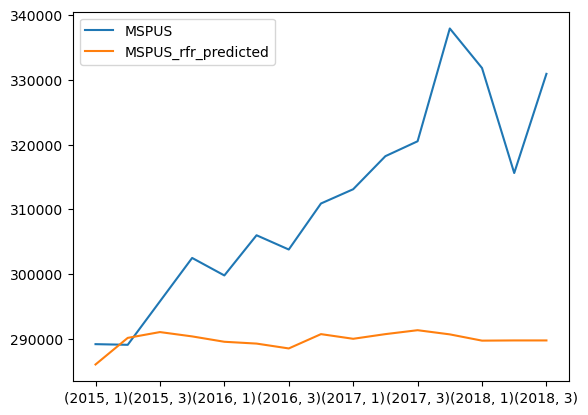

In [25]:
housing_predictions_df[['MSPUS', 'MSPUS_rfr_predicted']].plot()

In [26]:
# Create a K Nearest Neighbors Regressor model
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_scaled, y_train.values.ravel())
y_pred_knn = knn_model.predict(X_test_scaled)
housing_predictions_df["MSPUS_knn_predicted"] = y_pred_knn

<Axes: >

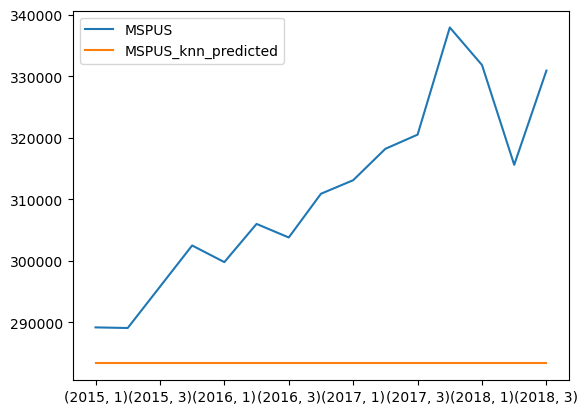

In [27]:
housing_predictions_df[['MSPUS', 'MSPUS_knn_predicted']].plot()

In [28]:
number_inputs = len(X_train_scaled[0])
number_inputs

12

In [29]:
model = Sequential()
model.add(Dense(units=6, activation="relu", input_dim=number_inputs)) 
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

In [30]:
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

# Transform test data using the same scaler
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

model.summary()

Epoch 1/50
2/2 [==============================] - 1s 158ms/step - loss: 0.4914 - val_loss: 0.8578
Epoch 2/50
2/2 [==============================] - 0s 25ms/step - loss: 0.4488 - val_loss: 0.7990
Epoch 3/50
2/2 [==============================] - 0s 26ms/step - loss: 0.4095 - val_loss: 0.7402
Epoch 4/50
2/2 [==============================] - 0s 24ms/step - loss: 0.3704 - val_loss: 0.6821
Epoch 5/50
2/2 [==============================] - 0s 22ms/step - loss: 0.3328 - val_loss: 0.6246
Epoch 6/50
2/2 [==============================] - 0s 25ms/step - loss: 0.2936 - val_loss: 0.5684
Epoch 7/50
2/2 [==============================] - 0s 26ms/step - loss: 0.2561 - val_loss: 0.5120
Epoch 8/50
2/2 [==============================] - 0s 24ms/step - loss: 0.2172 - val_loss: 0.4553
Epoch 9/50
2/2 [==============================] - 0s 22ms/step - loss: 0.1793 - val_loss: 0.3979
Epoch 10/50
2/2 [==============================] - 0s 24ms/step - loss: 0.1420 - val_loss: 0.3401
Epoch 11/50
2/2 [===========

In [31]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_pred

1/1 [==============================] - 0s 67ms/step


array([[256068.47],
       [254651.11],
       [257399.88],
       [259727.47],
       [260254.77],
       [269131.88],
       [276559.03],
       [275072.88],
       [284041.84],
       [296774.88],
       [300825.2 ],
       [308136.06],
       [318041.8 ],
       [336985.1 ],
       [341273.1 ]], dtype=float32)

In [32]:
housing_predictions_df["MSPUS_neural_predicted"] = y_pred

In [33]:
housing_predictions_df.head()

CPIAUCSL        HOUST  CSUSHPINSA  HPIPONM226S  WSCNDW01USQ470S  \
2015 1  235.355000   977.000000  166.989000   211.696667     82277.777778   
     2  236.960000  1158.000000  171.756333   214.556667     96305.555556   
     3  237.855000  1166.666667  174.826000   217.210000     96750.000000   
     4  237.837000  1125.333333  175.101333   220.340000     93694.444444   
2016 1  237.689333  1142.666667  175.637667   223.000000     96111.111111   

        ETOTALUSQ176N  USSTHPI  WPUSI012011  ILSTHPI  MORTGAGE30US  \
2015 1       134862.0   349.35   215.366667   311.87      3.716667   
     2       135081.0   355.02   213.966667   314.57      3.819231   
     3       135309.0   360.06   213.166667   315.66      3.954615   
     4       135552.0   362.96   211.666667   317.10      3.897857   
2016 1       135795.0   366.31   211.433333   318.55      3.738462   

        MORTGAGE15US    MSACSR     MSPUS  MSPUS_lr_predicted  \
2015 1      3.010833  4.800000  289200.0       289541.815424   
     2      3.056154  5.100000  289100.0       295665.420262   
     3      3.150769  5.366667  295800.0       299832.539000   
     4      3.123571  5.400000  302500.0       303688.316682   
2016 1      3.022308  5.533333  299800.0       308876.553358   

        MSPUS_dt_predicted  MSPUS_rfr_predicted  MSPUS_knn_predicted  \
2015 1            288000.0             286065.0             283340.0   
     2            281000.0             290167.0             283340.0   
     3            281000.0             291064.0             283340.0   
     4            281000.0             290396.0             283340.0   
2016 1            281000.0             289568.0             283340.0   

        MSPUS_neural_predicted  
2015 1           256068.468750  
     2           254651.109375  
     3           257399.875000  
     4           259727.468750  
2016 1           260254.765625

<Axes: >

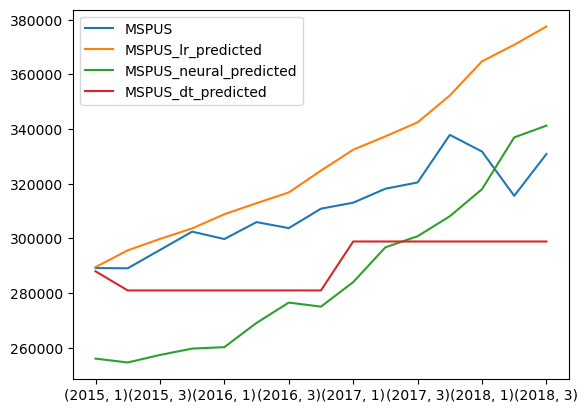

In [34]:
housing_predictions_df[['MSPUS', 'MSPUS_lr_predicted', 'MSPUS_neural_predicted', 'MSPUS_dt_predicted']].plot()